#### Jupyter Notebook to compute morphological metrics from axon and myelin segmentation


#### Imports

In [24]:
import numpy as np
from skimage import io
from scipy.misc import imread, imsave
import os
import imageio
import json
from skimage import transform
from skimage.filters import gaussian
import matplotlib.pyplot as plt
from shutil import copy
import math
from AxonDeepSeg.apply_model import axon_segmentation
from AxonDeepSeg.testing.segmentation_scoring import *
from scipy.misc import imread, imsave
from skimage import measure
from skimage.measure import regionprops
%matplotlib inline

#### Read image and segmented prediction

In [7]:
path_img = '/Users/rudinakaprata/Documents/Aldo/axondeepseg/AxonDeepSeg/data_test/image.png'
path_pred = '/Users/rudinakaprata/Documents/Aldo/axondeepseg/AxonDeepSeg/data_test/AxonDeepSeg.png'

img = imageio.imread(path_img)
pred = imageio.imread(path_pred)
pred_axon = pred > 200
pred_myelin = np.logical_and(pred >= 50, pred <= 200)
path_folder, file_name = os.path.split(path_img)

In [8]:
def get_pixelsize():

    text_file = open(os.path.join(path_folder,'pixel_size_in_micrometer.txt'), "r")
    pixelsize = float(text_file.read())
    text_file.close()
    return pixelsize

In [9]:
def get_axon_morphometrics(pred_axon):
    
    # Array for keeping axon-wise metrics
    stats_array = np.empty(0)

    # Label each axon object
    labels = measure.label(pred_axon)
    axon_objects = regionprops(labels)

    # Get axon morphometrics of interest
    for props in axon_objects:
    
        # Centroid
        y0, x0 = props.centroid
        # Solidity
        solidity = props.solidity
        # Eccentricity
        eccentricity = props.eccentricity
        # Axon equivalent diameter in micrometers
        axon_diam = (props.equivalent_diameter)*get_pixelsize()
        # Axon orientation angle
        orientation = props.orientation
    
        # Add metrics to list of dictionaries
        stats = {'y0': y0, 'x0': x0, 'axon_diam': axon_diam, 'solidity':solidity,'eccentricity': eccentricity,'orientation':orientation}
        stats_array = np.append(stats_array, [stats], axis=0)
        
    return stats_array

In [15]:
stats_array = get_axon_morphometrics(pred_axon)


In [42]:
def get_aggregate_morphometrics(pred_axon, pred_myelin):
    
    avf = np.count_nonzero(pred_axon)/float((pred_axon.size))
    mvf = np.count_nonzero(pred_myelin)/float((pred_myelin.size))
    
    gratio = math.sqrt(1/(1+(float(mvf)/float(avf))))
    
    stats_array = get_axon_morphometrics(pred_axon)
    axon_diam_list = [d['axon_diam'] for d in stats_array]
    mean_axon_diam = np.mean(axon_diam_list)
    
    mean_myelin_diam = mean_axon_diam/gratio
    
    mean_myelin_thickness = mean_myelin_diam - mean_axon_diam
    
    aggregate_metrics = {'avf': avf, 'mvf': mvf, 'gratio': gratio, 'mean_axon_diam': mean_axon_diam,'mean_myelin_diam': mean_myelin_diam,'mean_myelin_thickness': mean_myelin_thickness}

    
    return aggregate_metrics

In [43]:
aaa = get_aggregate_morphometrics(pred_axon,pred_myelin)
print aaa

{'mean_axon_diam': 2.5575044164131997, 'mean_myelin_thickness': 1.1878720648707208, 'mvf': 0.3438579081741404, 'mean_myelin_diam': 3.7453764812839205, 'avf': 0.30040214667696113, 'gratio': 0.6828430811143673}


In [32]:
avf = np.count_nonzero(pred_axon)
print avf

507360


In [35]:
gratio = math.sqrt(1/(1+(float(mvf)/float(avf))))
print gratio

0.682843081114


In [39]:
pred_axon.size

1688936

In [16]:
print stats.keys()

['axon_diam', 'solidity', 'eccentricity', 'y0', 'x0', 'orientation']


In [17]:
# Get axon diameter value of axon object 0
print stats_array[0]['axon_diam']

1.69958776035


In [18]:
# Get all stats for axon object 0
print stats_array[0]

{'axon_diam': 1.6995877603526874, 'solidity': 0.9605809128630706, 'eccentricity': 0.9739720454622895, 'y0': 5.280777537796976, 'x0': 116.99352051835854, 'orientation': -0.02154700130228092}


In [19]:
# Get axon diameter value of all axons in list
axon_diam_list = [d['axon_diam'] for d in stats_array]

In [20]:
# Get number of axons
print np.size(axon_diam_list)

296


In [21]:
# Get mean diameter
mean_diam = np.mean(axon_diam_list)
print mean_diam

2.572955000815824


In [23]:
import csv

with open(os.path.join(path_folder,'stats.csv'), 'wb') as myfile:
    wr = csv.writer(myfile, delimiter=',', quotechar='"', quoting=csv.QUOTE_ALL)
    wr.writerow(stats_array)


In [21]:
import csv
keys = stats_array[0].keys()
with open(os.path.join(path_folder,'stats.csv'), 'wb') as output_file:
    dict_writer = csv.DictWriter(output_file, keys)
    dict_writer.writeheader()
    dict_writer.writerows(stats_array)

AttributeError: '_csv.writer' object has no attribute 'writeheader'

In [ ]:
writer = csv.writer(ofile, delimiter='', quotechar='"', quoting=csv.QUOTE_ALL)
 

In [129]:
with open(os.path.join(path_folder,'stats.csv'), 'wb') as output:
    writer = csv.writer(output)
    for each in stats_array:
        for key, value in each.iteritems():
            writer.writerow([key, value])

In [133]:
class Axon:
    def __init__(self,x0=None,y0=None,axon_diam=None):
        self.__x0=x0
        self.__y0=y0
        self.__axon_diam=axon_diam
    def getDiameter(self):
        return self.__axon_diam
    def getPosx(self):
        return self.__x0
    def getPosy(self):
        return self.__y0
    def __hash__(self):
        return hash((self.__axon_diam,self.__x0,self.__y0))
    def __eq__(self, other):
        return self.__axon_diam,self.__x0,self.__y0==other.__axon_diam,other.__x0,other.__y0
    def toArray(self):
        return [self.__x0,
            self.__y0,
            self.__axon_diam]

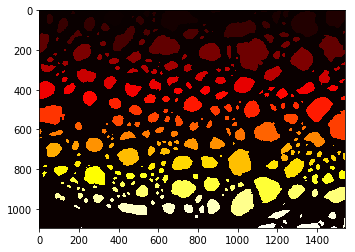

In [29]:
labels = measure.label(pred_axon)
axon_objects = regionprops(labels)



plt.imshow(labels,cmap='hot')

imageio.imwrite('aaa.png', labels)


In [171]:
labels(1150,600)

TypeError: 'numpy.ndarray' object is not callable

In [172]:
print np.min(labels)

0


In [23]:


axon_diam_list = [d['axon_diam'] for d in stats_array]

axon_iter = np.arange(np.size(axon_diam_list))


for pix_x in np.arange(np.shape(labels)[0]):
       for pix_y in np.arange(np.shape(labels)[1]):
            labels[pix_x,pix_y] = axon_diam_list[labels[pix_x,pix_y]]




IndexError: list index out of range

In [25]:
labels==2

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [26]:
axon_iter = np.arange(np.size(axon_diam_list))

In [24]:
np.size(pred_axon)

1688936